<a href="https://colab.research.google.com/github/youbj/2022_Finking/blob/yglee/nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [216]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
import pandas as pd
from sklearn.model_selection import train_test_split
import gluonnlp as nlp
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
device = torch.device("cuda:0")
bertmodel, vocab = get_pytorch_kobert_model()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [126]:
file_test='/content/sample_data/finance_data.csv'

In [ ]:
df = pd.read_csv(file_test, encoding='cp949')
df.dropna(axis=0)

In [185]:
del df['sentence']

In [187]:
print('결측값 여부 :',df.isnull().values.any())

결측값 여부 : False


In [190]:
print('kor_sentence 열의 유니크한 값 :',df['kor_sentence'].nunique())

kor_sentence 열의 유니크한 값 : 4827


duplicate

In [193]:
duplicate = df[df.duplicated()]
df.drop_duplicates(subset=['kor_sentence'], inplace=True)
print('총 샘플 수 :',len(df))

총 샘플 수 : 4827


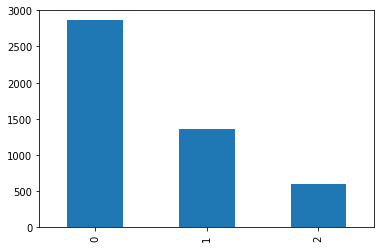

In [194]:
df['labels'].value_counts().plot(kind='bar')

In [196]:
data_train, data_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df['labels'])

In [197]:
print('훈련 샘플의 개수 :', len(data_train))
print('테스트 샘플의 개수 :', len(data_test))

훈련 샘플의 개수 : 3861
테스트 샘플의 개수 : 966


In [ ]:
data_train

In [142]:
neu_train=round(data_train['labels'].value_counts()[0]/len(data_train) * 100,3)
pos_train=round(data_train['labels'].value_counts()[1]/len(data_train) * 100,3)
neg_train=round(data_train['labels'].value_counts()[2]/len(data_train) * 100,3)

neu_test=round(data_test['labels'].value_counts()[0]/len(data_test) * 100,3)
pos_test=round(data_test['labels'].value_counts()[1]/len(data_test) * 100,3)
neg_test=round(data_test['labels'].value_counts()[2]/len(data_test) * 100,3)

In [143]:
print('--------훈련 데이터의 비율-----------')
print('중립 = ',neu_train,'%');
print('긍정 = ',pos_train,'%')
print('부정 = ',neg_train,'%')

--------훈련 데이터의 비율-----------
중립 =  59.285 %
긍정 =  28.205 %
부정 =  12.51 %


In [144]:
print('--------테스트 데이터의 비율-----------')
print('중립 = ',neu_test,'%');
print('긍정 = ',pos_test,'%')
print('부정 = ',neg_test,'%')

--------테스트 데이터의 비율-----------
중립 =  59.213 %
긍정 =  28.261 %
부정 =  12.526 %


문제점

In [199]:
data_train.to_csv('train.tsv', sep='\t',encoding="utf-8", index=False)
data_test.to_csv('test.tsv', sep='\t',encoding="utf-8", index=False)
dataset_train = nlp.data.TSVDataset('train.tsv',num_discard_samples=1)
dataset_test = nlp.data.TSVDataset('test.tsv',num_discard_samples=1)

In [202]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


학습할 때 사용할 데이터셋 클래스 선언

In [203]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [204]:
##Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate= 5e-5

In [205]:
np.int64(data_train['labels'])

array([1, 1, 1, ..., 2, 0, 1])

In [206]:
data_train['labels'].dtype

dtype('int64')

In [208]:
data_train = BERTDataset(dataset_train, 1, 0, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 1, 0, tok, max_len, True, False)

In [212]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [210]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=3,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        return self.classifier(out)

In [211]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [213]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [217]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [218]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [219]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [220]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [221]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        train_acc += calc_accuracy(out, label)
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 1 train acc 0.6167544886807182


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/16 [00:00<?, ?it/s]

epoch 1 test acc 0.7672526041666666


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 2 train acc 0.8365656713505074


  0%|          | 0/16 [00:00<?, ?it/s]

epoch 2 test acc 0.8528645833333334


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 3 train acc 0.8972848360655737


  0%|          | 0/16 [00:00<?, ?it/s]

epoch 3 test acc 0.869140625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 4 train acc 0.944672131147541


  0%|          | 0/16 [00:00<?, ?it/s]

epoch 4 test acc 0.87109375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 5 train acc 0.9631147540983607


  0%|          | 0/16 [00:00<?, ?it/s]

epoch 5 test acc 0.873046875


In [222]:
def softmax(vals, idx):
    valscpu = vals.cpu().detach().squeeze(0)
    a = 0
    for i in valscpu:
        a += np.exp(i)
    return ((np.exp(valscpu[idx]))/a).item() * 100

In [227]:
def testModel(model, seq):
    cate = ["중립", "긍정", "부정"]
    tmp = [seq]
    transform = nlp.data.BERTSentenceTransform(tok, max_len, pad=True, pair=False)
    tokenized = transform(tmp)

    model.eval()
    result = model(torch.tensor([tokenized[0]]).to(device), [tokenized[1]], torch.tensor(tokenized[2]).to(device))
    idx = result.argmax().cpu().item()
    print("뉴스의 감정 :", cate[idx])
    print("신뢰도는:", "{:.2f}%".format(softmax(result,idx)))

In [228]:
testModel(model, "삼성 前임원 특허공격, 美법원서 '자격 박탈'")

뉴스의 감정 : 부정
신뢰도는: 95.50%


In [229]:
testModel(model, "고화질 카메라 탑재 늘리는 삼성전자·애플…국내 기업 수혜 예상")

뉴스의 감정 : 긍정
신뢰도는: 98.06%


In [230]:
testModel(model, "[단독] ‘기술 인재’ 중시 삼성, 우수 엔지니어 위한 직책 신설")

뉴스의 감정 : 중립
신뢰도는: 97.49%
